In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import glob
import os
import math
import re

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
from matplotlib import font_manager as fm, rcParams
from pathlib import Path


from umap.umap_ import UMAP

from pointgrid import align_points_to_grid

# t-SNE
from sklearn.manifold import TSNE

#hdbscan
import hdbscan

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
# Import
path_in = 'data/csv/freihand_signatures.csv'

df = pd.read_csv(path_in)
df = df.fillna('')

# Filter out the rows with missing values
df_filtered = df[df.inventory_year != '']

# 10'000 sample points for fast plotting
df = df.sample(20000)
df_filtered = df_filtered.sample(10000)

In [39]:
# text cols for wordclouds, cluster cols for clustering
text_cols = ['text', 'text_3', 'text_2', 'text_1']
cluster_cols = ['sig_lev_1', 'sig_lev_2', 'sys']

# Perform one-hot encoding on the cluster_cols
df_cluster_1 = pd.get_dummies(df[cluster_cols[0]])
df_cluster_2 = pd.get_dummies(df[cluster_cols[1:3]])


# Import Functions

In [40]:
#Normalize 
def normalize(emb):

    embedding = emb * 100 # Multiply by 100
    embedding = align_points_to_grid(embedding)

    # Swap axes for horizontal position

    ptp = np.ptp(embedding, axis=0)
    if ptp[1]> ptp[0]:
        embedding[:, [1, 0]] = embedding[:, [0, 1]]

    # Set range of values normalized to dimension with higher extent

    extent = (embedding[:,0].min(), embedding[:,0].max()) if (embedding[:,0].max() - embedding[:,0].min()) > (embedding[:,1].max() - embedding[:,1].min()) else (embedding[:,1].min(), embedding[:,1].max())
    resolution = (-1000, 1000)

    embedding[:, 0] = np.interp(embedding[:,0], extent, resolution)
    embedding[:, 1] = np.interp(embedding[:,1], extent, resolution)

    # # Set origin at the middle

    # ptp = np.ptp(embedding, axis=0)  
    # embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
    # embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

    embedding = embedding.astype(int) # Set integer

    return embedding

def normalize_cluster(embedding, cluster_extent):
    # Multiply by 100
    embedding = embedding * 100
    embedding = align_points_to_grid(embedding)

    # Swap axes for horizontal position
    ptp = np.ptp(embedding, axis=0)
    if ptp[1] > ptp[0]:
        embedding[:, [1, 0]] = embedding[:, [0, 1]]

    # Set range of values normalized to dimension with higher extent
    extent = (embedding[:,0].min(), embedding[:,0].max()) if (embedding[:,0].max() - embedding[:,0].min()) > (embedding[:,1].max() - embedding[:,1].min()) else (embedding[:,1].min(), embedding[:,1].max())
    resolution = (cluster_extent[0], cluster_extent[1])

    embedding[:, 0] = np.interp(embedding[:, 0], extent, resolution)
    embedding[:, 1] = np.interp(embedding[:, 1], extent, resolution)

    # Set origin at the middle
    # ptp = np.ptp(embedding, axis=0)  
    # embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
    # embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

    embedding = embedding.astype(int) # Set integer
    return embedding


In [41]:
subject_dict= {'A': 'Manuals', 'B': 'Italian Art', 'C': 'Italian Artists', 'D': 'Rome','E':'Italian Topography', 'F': 'Travel Literature', 'G': 'Sources', 'H': 'Iconography', 
               'J': 'Ornament','K': 'Kat and K', 'L': 'Congress Publications', 'M': 'Art in General', 'N': 'Architecture', 'O':'Sculpture', 'P': 'Painting', 'Q': 'Manuscript Illumination', 'R': 'Graphic Arts', 
               'S': 'Applied Arts', 'T': 'Collecting Art etc.', 'U': 'Registers of Artistic Monuments', 'V': 'Cultural Institutions', 'W': 'Non-Italian Artists','X': 'European Topography', 'Y': 'World Topography', 'Z': 'Related Disciplines', ' ': 'None'}


# Get the extent of a cluster
def get_cluster_extent(embedding, cluster_indices):
    cluster_emb = embedding[cluster_indices, :]
    extent = np.ptp(cluster_emb, axis=0)
    return extent

def plot_cluster_embeddings(df, clusters, embeddings, param_names, num_cols=2):
    # Create a subplot grid for the scatterplots
    num_plots = len(clusters)
    num_cols = num_cols
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axs = axs.flatten()

    # Loop over clusters and plot the corresponding embeddings
    for i, cluster in enumerate(clusters):

        df_cl = df.iloc[cluster]
        # Extract the embeddings for the current cluster
        object = embeddings[i][0]
        embedding = embeddings[i][1]
        
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df_cl.sig_lev_2, ax=axs[i], s=10)

        # Set the title of the plot based on the specified parameters
        title_params = {param_name: getattr(object, param_name) for param_name in param_names}
        title_str = ', '.join(f'{param_name}: {title_params[param_name]}' for param_name in param_names)
        axs[i].set_title(title_str)

    # Show the scatterplots
    plt.show()

In [42]:
# Clusters
def cluster_embeddings(embedding, min_cluster_size= 50):

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_method ='leaf')

    clusterer.fit(embedding)
    clusters = clusterer.labels_

    #Grouping by cluster
    values = set(clusters)
    if -1 in values: values.remove(-1)
    clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

    return clusters


def run_umap_on_clusters(df, clusters, n_neighbors = 10, metric = 'hamming', min_dist = 0.0):
    embeddings = []
    for cluster in clusters:
        # extract data for current cluster
        data = df.iloc[cluster, :].values
        # apply UMAP to the data
        
        umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist, 
                                    spread=1.0, random_state=42, verbose=False)
        x_umap = umap.fit_transform(data)
        embeddings.append((umap, x_umap))
    return embeddings 

## UMAP on sig_lev_1

In [43]:
%%time

n_neighbors = 100
metric = 'russellrao' #Russel Rao distance computes the difference between two binary arrays
min_dist = 0.2

umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist, 
                                 spread=1.0, random_state=42, verbose=False)
x_umap = umap.fit_transform(df_cluster_1)
embedding_1 = x_umap

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


CPU times: user 16min 34s, sys: 6.45 s, total: 16min 40s
Wall time: 3min 11s


## Clustering 

In [55]:
# Clustering

def cluster_embeddings(embedding, min_cluster_size= 50):

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_method ='leaf')
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    #Grouping by cluster
    values = set(clusters)
    if -1 in values: values.remove(-1)
    clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

    return clusters


# Find good clustering parameters
def plot_clustering_params(embedding, min_cluster_sizes, clusterings): 

    for i, clusters in enumerate(clusterings):

        # Get the most frequent signature type in each cluster
        cluster_labels = []
        for j, cluster_points in enumerate(clusters):
            cluster_signature_counts = df.iloc[cluster_points].sig_lev_1.value_counts()
            most_frequent_signature = cluster_signature_counts.index[0]

            clean_label = subject_dict[most_frequent_signature]
            cluster_labels.append(f'Cluster {j} {most_frequent_signature} : {clean_label}')


        # order and font
        order = sorted(df.signature.astype(str).str[0].unique())
        font_props = {'family': 'sans-serif', 'weight': 'normal', 'size': 12}

        #Plot the embedding and the clusters
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the embedding
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df.signature.astype(str).str[0], hue_order=order, ax=ax1, s=10)
        ax1.set_title('Umap Embedding')

        # Plot the clusters
        for cluster_index, cluster_points in enumerate(clusters):
            sns.scatterplot(x=embedding[cluster_points, 0], y=embedding[cluster_points, 1],
                            color=f"C{cluster_index}", ax=ax2, s=10)
            
            # Cluster labels in the middle of the cluster
            centroid = np.mean(embedding[cluster_points, :], axis=0)
            ax2.annotate(cluster_labels[cluster_index], xy=(centroid[0], centroid[1]), xytext=(0, 0),
                        textcoords='offset pixels', ha='center', va='center', fontweight='bold', fontsize=10, font = 'Helvetica')
            

        ax2.set_title(f'Clusters, min_cluster_size: {min_cluster_sizes[i]}', fontdict= font_props)
        plt.tight_layout()
        
        # Show the plot
        plt.show()

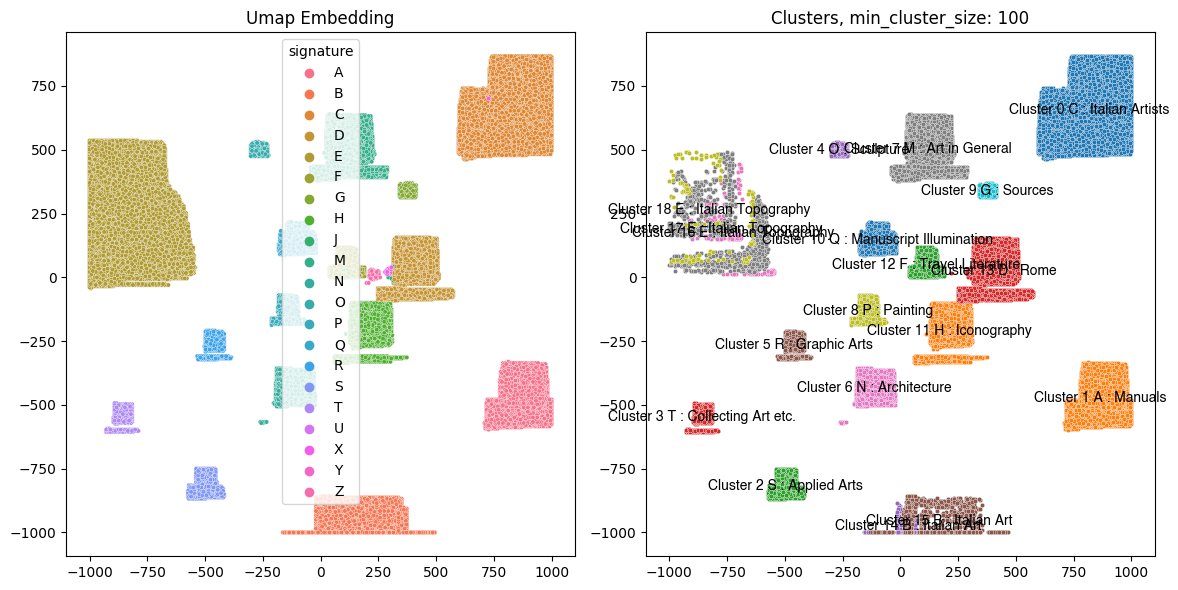

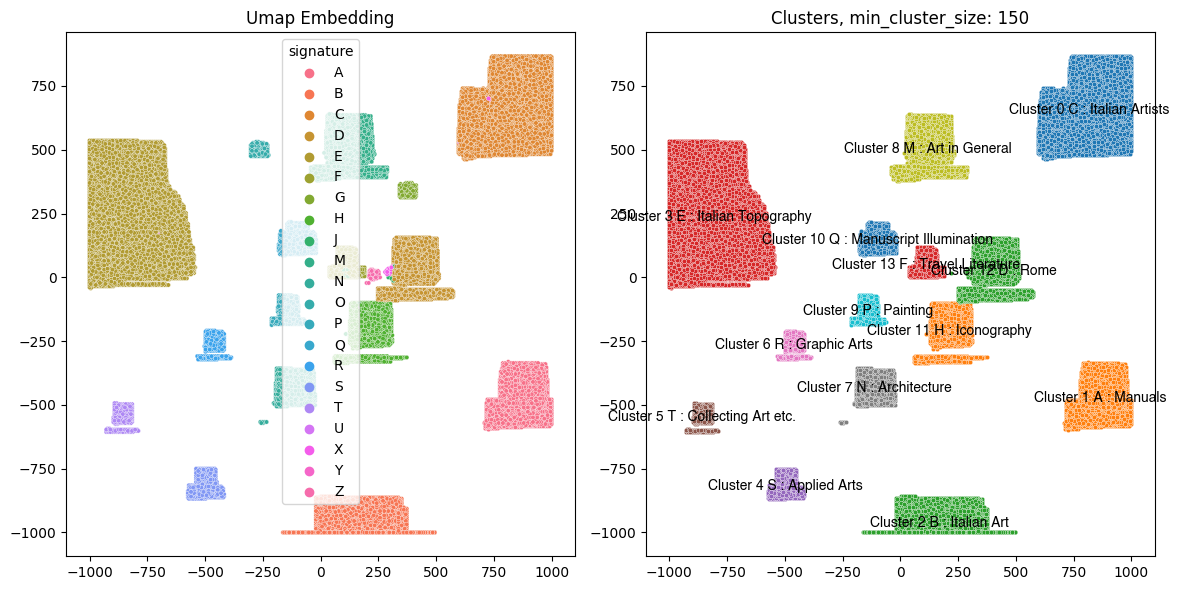

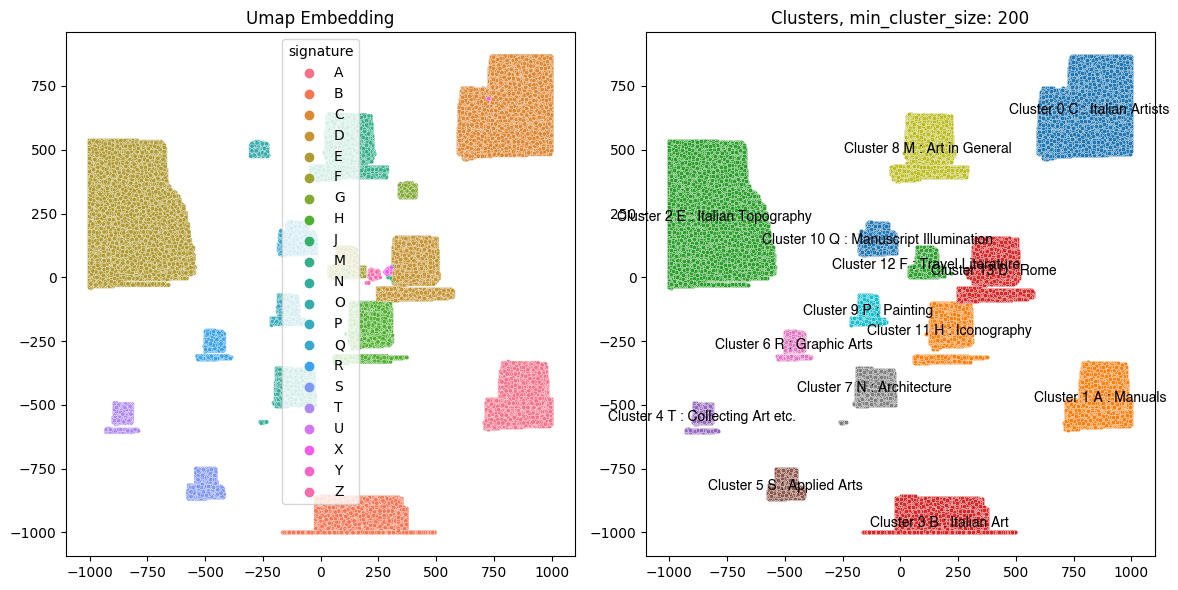

In [56]:
min_cluster_sizes = [100, 150, 200] # this needs to be scaled as the dataset is scaled
clusterings = []
for size in min_cluster_sizes: 
    # Get clusters on original embedding
        clusters = cluster_embeddings(embedding_1, size)
        clusterings.append(clusters)


normalized_embedding = normalize(embedding_1)
plot_clustering_params(normalized_embedding, min_cluster_sizes, clusterings)

## UMAP on sig_lev_2

In [49]:
# Choose best clustering here
clusters = clusterings[1]

In [51]:
def run_umap_on_clusters(df, clusters, n_neighbors = 10, metric = 'hamming', min_dist = 0.0):

    embeddings = []

    for cluster in clusters:

        # extract rows for current cluster
        rows = df.iloc[cluster, :].values

        umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist,spread=1.0, random_state=42, verbose=False)
        x_umap = umap.fit_transform(rows)
        embeddings.append((umap, x_umap))

    return embeddings 

In [52]:
# Compute umap for each cluster 
n_neighbors = 20
metric = 'russellrao'
min_dist = 0.1
embeddings_2 = []

for i, cluster in enumerate(clusters):

    # Extract data for current cluster
    data = df_cluster_2.iloc[cluster, :]
    rows = df.iloc[cluster, :]
    cluster_emb = embedding_1[cluster, :]

    # Apply UMAP to the cluster again
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist,
                spread=1.0, random_state=42, verbose=False)
    x_umap = umap.fit_transform(data)

    embeddings_2.append(x_umap)

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellra

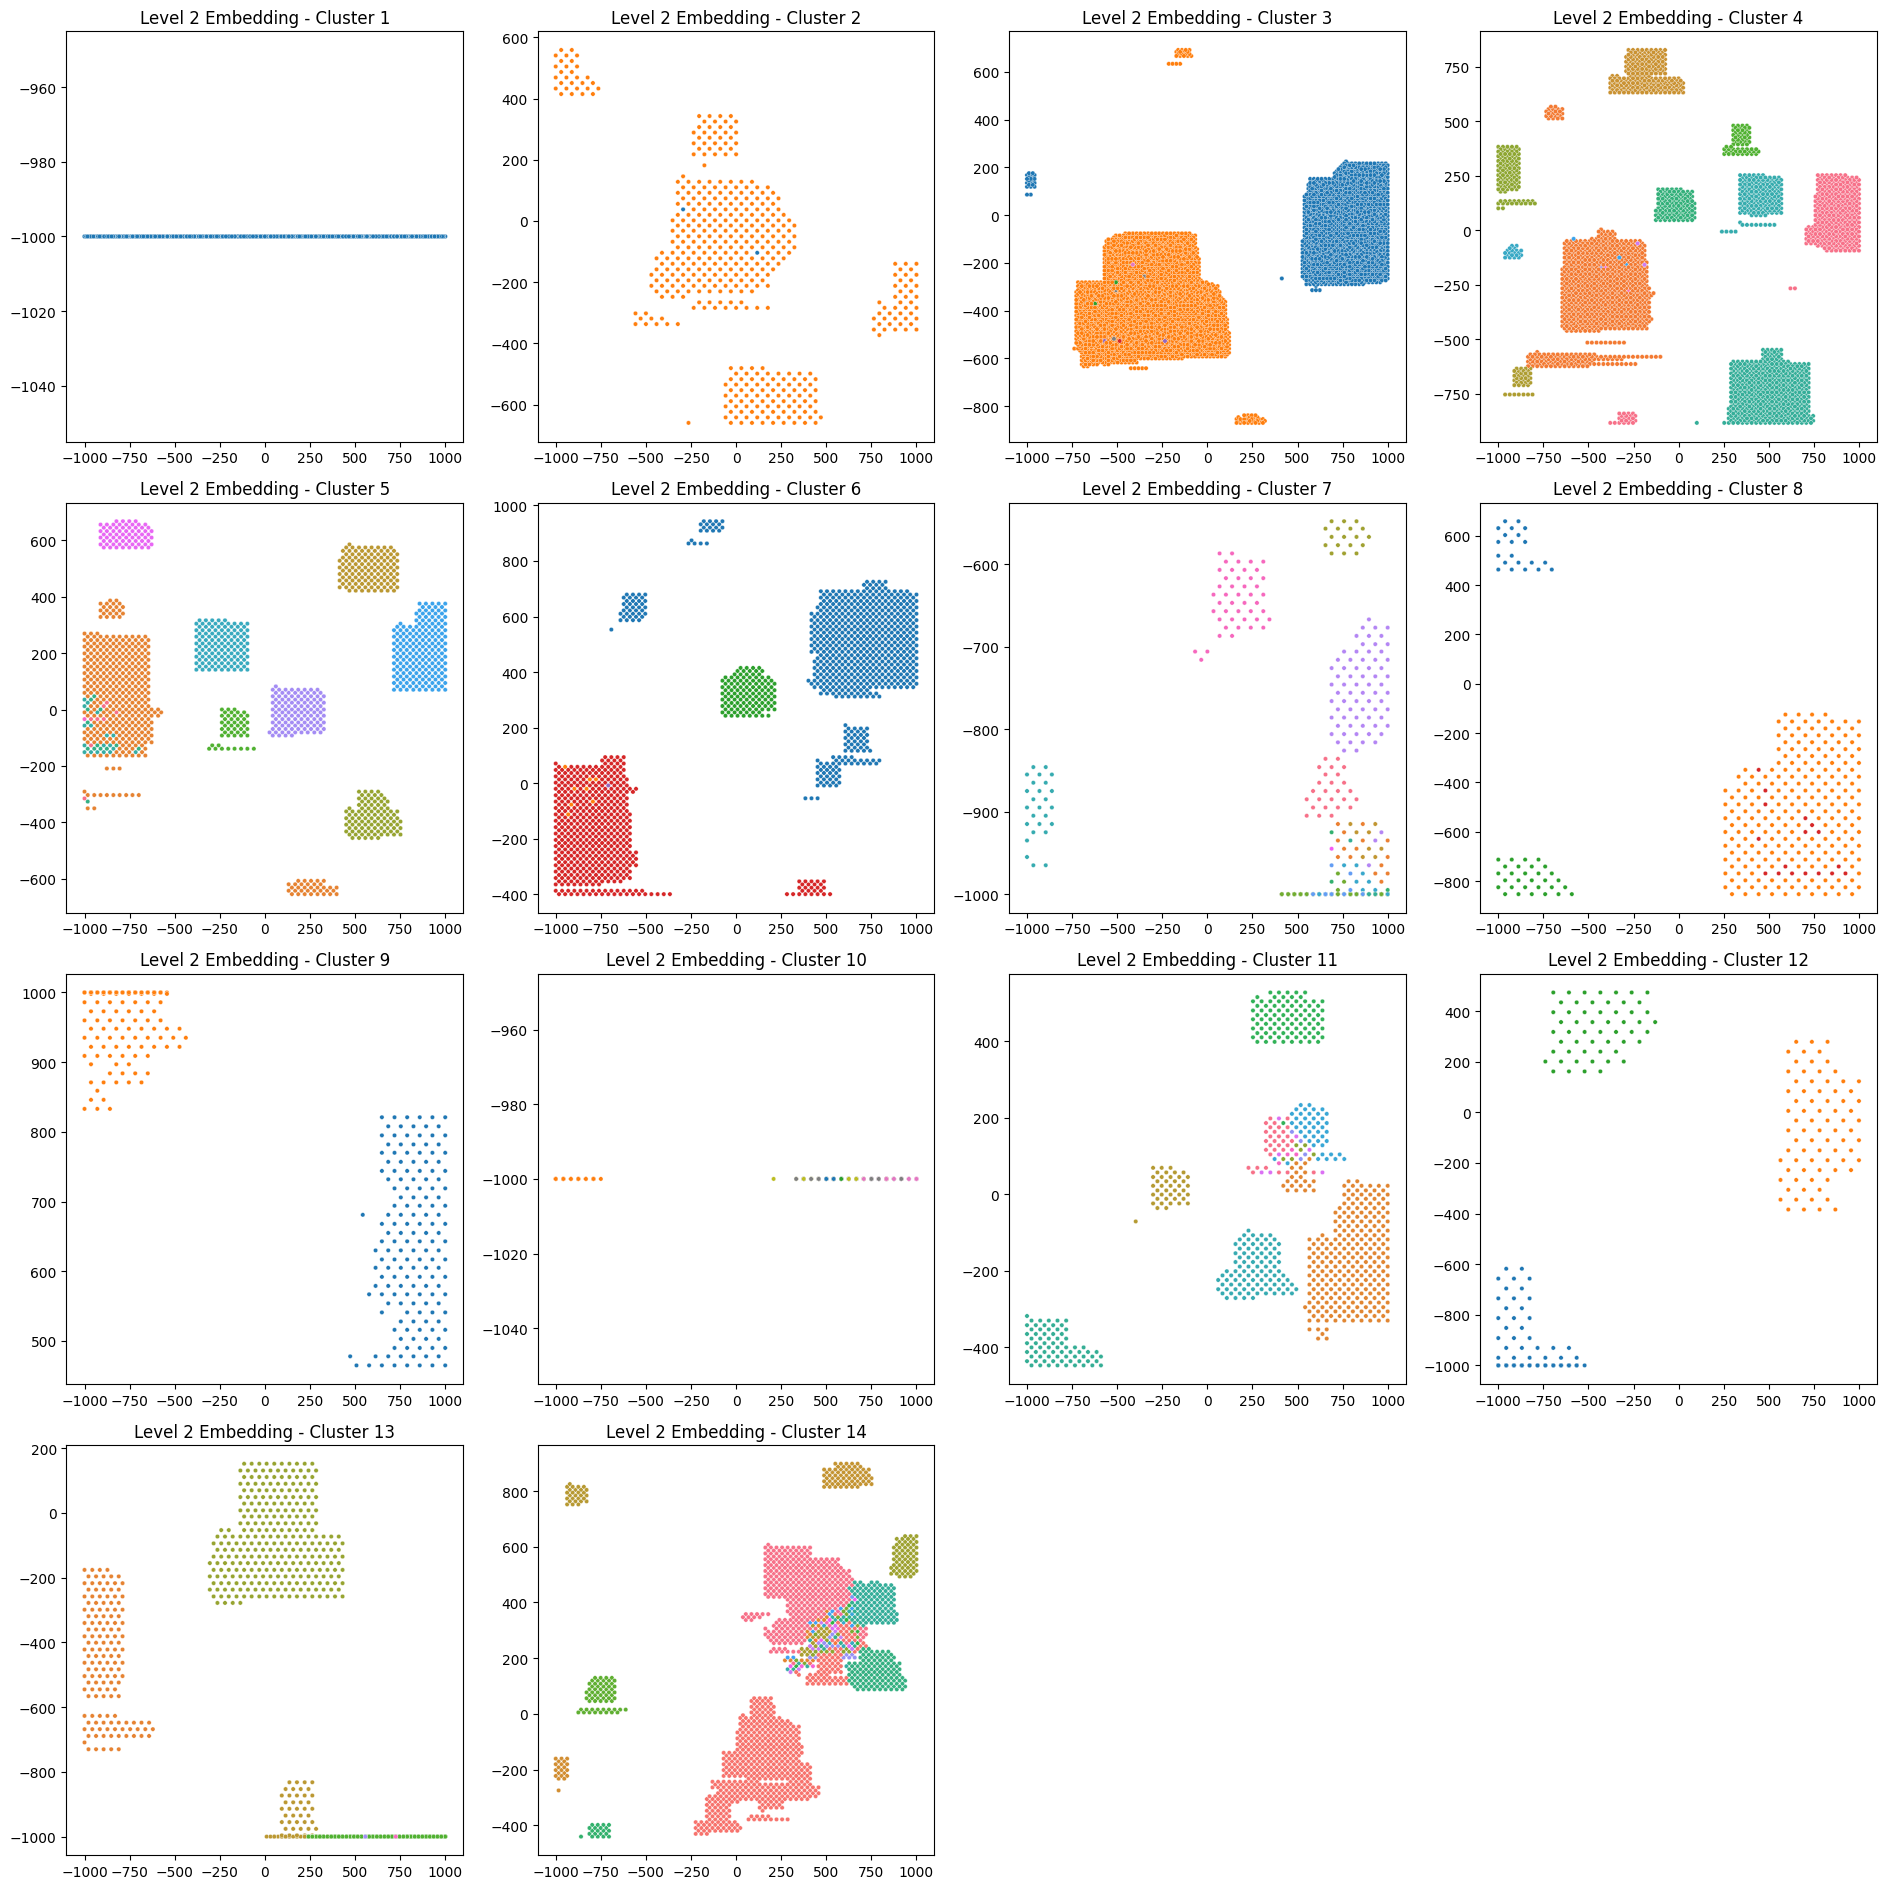

In [35]:
n_clusters = len(clusters)
n_rows = int(np.ceil(np.sqrt(n_clusters)))
n_cols = int(np.ceil(n_clusters / n_rows))

# Create the subplots for the level 2 embeddings
fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 19))
axes = axes.flatten()

for i, cluster in enumerate(clusters):

    #normalized_embedding_2 = normalize(embeddings_2[i])
    
    # Plot the level 2 embedding
    order_level2 = sorted(rows.sig_lev_2.unique())
    sns.scatterplot(x=embeddings_2[i][:, 0], y=embeddings_2[i][:, 1],
                    hue=rows.sig_lev_2, hue_order=order_level2, ax=axes[i], s=10)
    axes[i].set_title('Level 2 Embedding - Cluster {}'.format(i + 1))
    axes[i].get_legend().remove()


# Hide any extra subplots
for j in range(n_clusters, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

